In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import col, floor
from pyspark.sql.functions import col, avg, count, stddev
from pyspark.sql.functions import when
from pyspark.sql.functions import col, avg, count, stddev, sqrt, pow

import seaborn as sns
from pyspark.sql.types import DoubleType, FloatType
from pyspark.ml.feature import VectorAssembler

In [4]:
spark = SparkSession.builder \
    .appName("Car_Price") \
    .getOrCreate()

In [92]:
Car_Price = spark.read.csv('/content/car_prices.csv', sep=',', inferSchema=True, header=True)
#Car_Price= spark.read.option("header", "true").csv(file_Path, inferSchema=True)
Car_Price.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: integer (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)



In [93]:
Car_Price.show(5)

+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|year| make|              model|      trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|            saledate|
+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg566472|   ca|        5|   16639|white|   black|kia motors americ...|20500|       21500|Tue Dec 16 2014 1...|
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg561319|   ca|        5|    9393|white|   beige|kia motors americ...|20800|       21500|Tue Dec 16 2014 1...|
|2014|  BMW|           3 Series|328i SULEV|Sedan|   automatic|wba3c1c51ek116351|   ca|    

In [94]:
#Checking for summary statistics
summary=Car_Price.summary()
summary.show()

+-------+-----------------+------+-----------------+------------------+----------+------------+-----------------+-----------------+------------------+-----------------+-----------------+--------+--------------------+------------------+------------------+--------------------+
|summary|             year|  make|            model|              trim|      body|transmission|              vin|            state|         condition|         odometer|            color|interior|              seller|               mmr|      sellingprice|            saledate|
+-------+-----------------+------+-----------------+------------------+----------+------------+-----------------+-----------------+------------------+-----------------+-----------------+--------+--------------------+------------------+------------------+--------------------+
|  count|           558837|548536|           548438|            548186|    545642|      493485|           558833|           558837|            547017|           558743|    

In [95]:
#Count of Observations
Car_Price.count()

558837

In [96]:
# Count of nulls in each column
null_counts = Car_Price.select([count(when(col(c).isNull(), c)).alias(c) for c in Car_Price.columns])
null_counts.show()

+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65352|  4|    0|    11820|      94|  749|     749|     0| 38|          12|      12|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



In [97]:
#Droping Na values so has few impact on the analysis
Car_Price_Clean=Car_Price.na.drop()

In [98]:
null_counts_c = Car_Price_Clean.select([count(when(col(c).isNull(), c)).alias(c) for c in Car_Price_Clean.columns])
null_counts_c.show()

+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year|make|model|trim|body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|   0|    0|   0|   0|           0|  0|    0|        0|       0|    0|       0|     0|  0|           0|       0|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



In [99]:
Car_Price_Clean = Car_Price_Clean.filter(col("condition") > 5)

#Count of Observations
Car_Price_Clean.count()

413590

In [100]:
# Convert Spark DataFrame to Pandas for visualization
Car_Price_df = Car_Price_Clean.toPandas()

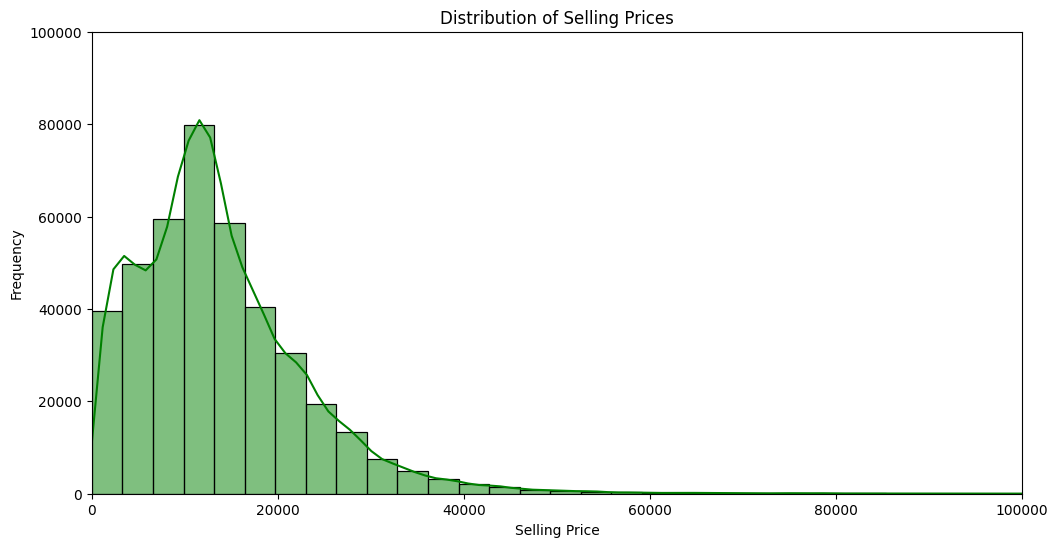

In [101]:
# Visualize distributions
plt.figure(figsize=(12, 6))
sns.histplot(Car_Price_df['sellingprice'], kde=True, color='Green', bins=70)
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.title('Distribution of Selling Prices')
plt.xlim(0, 100000)  # Adjust x-axis limit
plt.ylim(0, 100000)   # Adjust y-axis limit
plt.show()

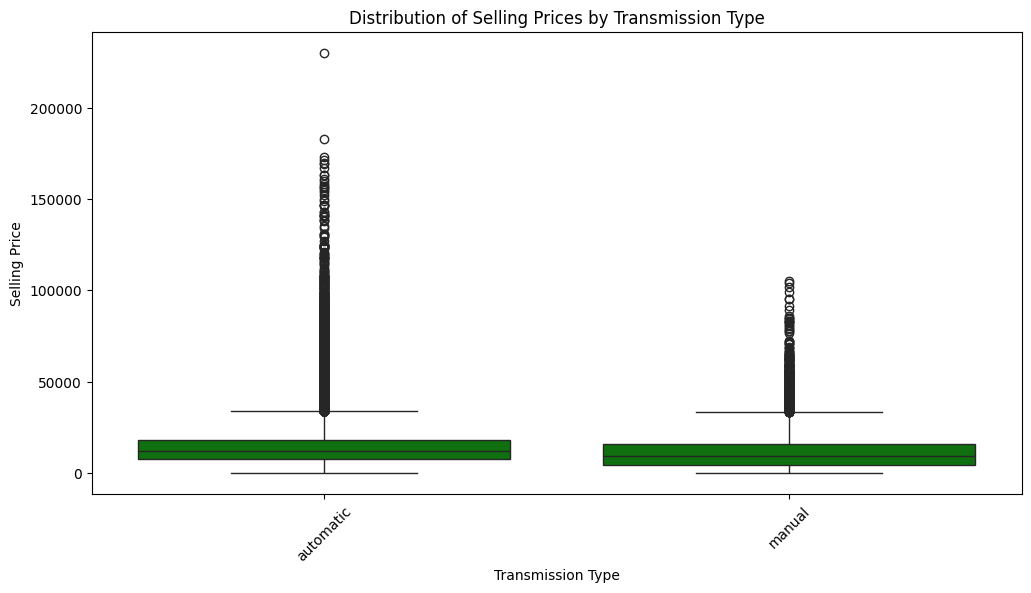

In [102]:
# Visualize distribution of selling price per transmission type
plt.figure(figsize=(12, 6))
sns.boxplot(data=Car_Price_df, x='transmission', y='sellingprice', color='Green')
plt.title('Distribution of Selling Prices by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Selling Price')
plt.xticks(rotation=45)  # Rotate x labels if they are long or overlap
plt.show()

<ipython-input-103-755e00894587>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='condition', y='sellingprice', data=Car_Price_df, ci=None, color='Green')


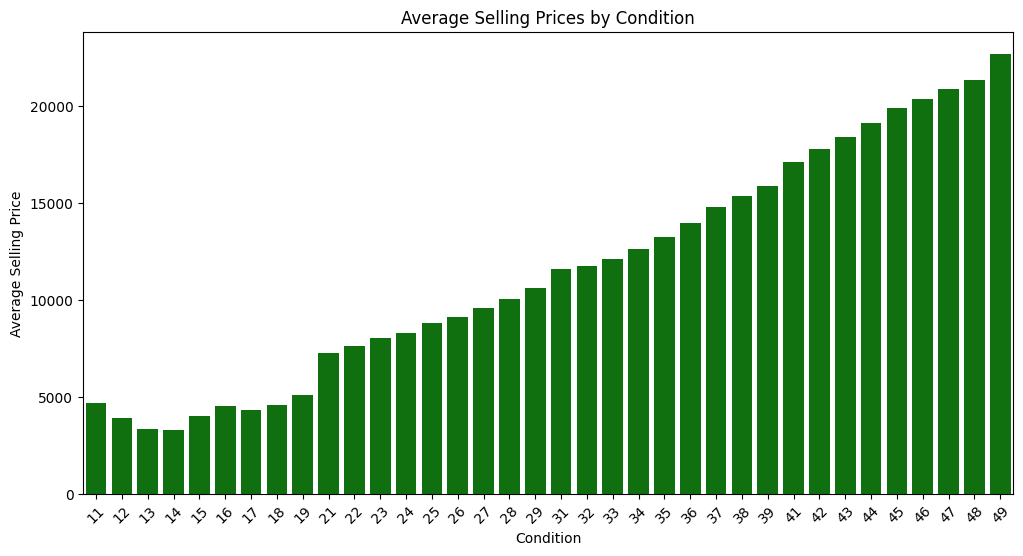

In [103]:
plt.figure(figsize=(12, 6))
sns.barplot(x='condition', y='sellingprice', data=Car_Price_df, ci=None, color='Green')
plt.title('Average Selling Prices by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Selling Price')
plt.xticks(rotation=45)
plt.show()

In [105]:
#Correlation Analysis**:
numeric_cols = Car_Price_df.select_dtypes(include=['number']).columns
correlation_matrix = Car_Price_df[numeric_cols].corr()
# Print the correlation matrix
display(correlation_matrix)


,year,condition,odometer,mmr,sellingprice
year,1.000000,0.547430,-0.778795,0.578889,0.571445
condition,0.547430,1.000000,-0.544397,0.467902,0.514369
odometer,-0.778795,-0.544397,1.000000,-0.580704,-0.578242
mmr,0.578889,0.467902,-0.580704,1.000000,0.985025
sellingprice,0.571445,0.514369,-0.578242,0.985025,1.000000


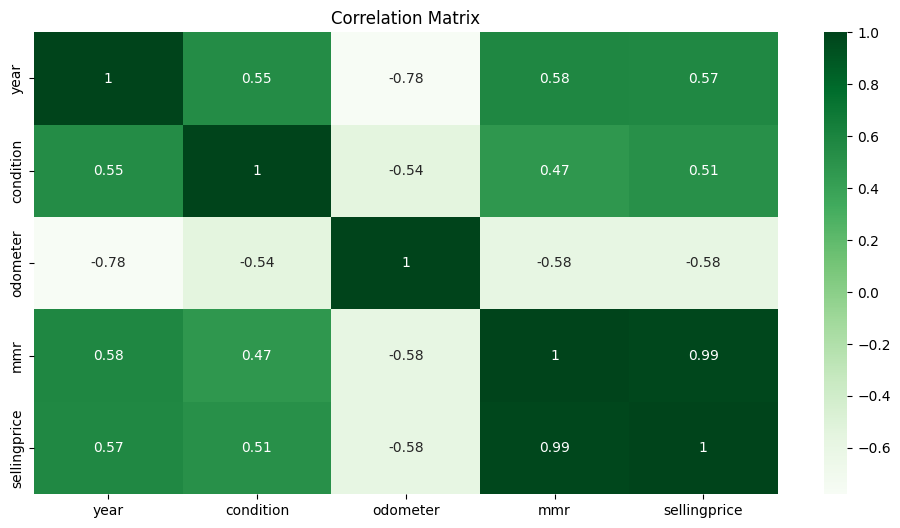

In [107]:
#Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
plt.title('Correlation Matrix')
plt.show()

In [108]:
spark = SparkSession.builder.appName("RevertToSpark").getOrCreate()
from pyspark.ml.feature import VectorAssembler

In [109]:
feature_columns = ["year", "condition", "odometer", "mmr"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(Car_Price_Clean)

In [110]:
from pyspark.ml.feature import StringIndexer

# Create a list of StringIndexer objects for each string column
string_indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in ["make", "model", "trim", "body", "transmission", "vin", "state", "color", "interior", "seller", "saledate"]]

# Fit the StringIndexer objects to the data
for string_indexer in string_indexers:
    string_indexer.fit(data)

# Transform the data using the StringIndexer objects
for string_indexer in string_indexers:
  data = string_indexer.fit(data).transform(data)

# Update the feature_columns list to include the indexed columns
feature_columns = ["year", "condition", "odometer", "mmr"] + [col+"_index" for col in ["make", "model", "trim", "body", "transmission", "vin", "state", "color", "interior", "seller", "saledate"]]

# Use VectorAssembler to assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="new_features")
data = assembler.transform(data)

In [111]:
##Splitting the data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [112]:
##Linear Regression Model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="new_features", labelCol="sellingprice")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

In [113]:
predictions = lr_model.transform(test_data)
predictions = predictions.withColumn("residuals", predictions["sellingprice"] - predictions["prediction"])
predictions.select("sellingprice", "prediction").show()

+------------+------------------+
|sellingprice|        prediction|
+------------+------------------+
|        1200|1190.2642429663974|
|         850| 853.7933167633018|
|        1350|1470.2095418414392|
|        1700|1807.7877620865183|
|        2000| 2294.143979950022|
|        3400|2697.2199155752896|
|        3300| 4339.574979552563|
|         300|459.28967647932586|
|         400| 1064.134142765106|
|         250|1143.3863513183023|
|        5500|3525.1228308042337|
|        1400|2001.8458766012336|
|        3000|2537.5649526913185|
|         500| 651.5755223139713|
|        3100| 4576.886384587066|
|        1200|1352.7535165043082|
|        1300| 879.4813277219946|
|         700|  848.451347716531|
|        2800|2996.9220453891903|
|         750| 2140.869053727889|
+------------+------------------+
only showing top 20 rows



In [114]:
# Import necessary modules
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Assuming the predictions DataFrame is created from a model
# For example, if using a previously trained model:
# model = ... (some trained model)
# test_data = ... (your test data)

# Transform the test data using the trained model
predictions = lr_model.transform(test_data) # Use lr_model here

# Check if predictions DataFrame is not None
if predictions is not None:
    # Calculate residuals (overwrite predictions DataFrame)
    predictions = predictions.withColumn("residuals", col("sellingprice") - col("prediction"))

    # Display residuals
    predictions.show(5)

    # Calculate evaluation metrics
    evaluator_rmse = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="rmse")

    # Calculate and print RMSE
    rmse = evaluator_rmse.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Error: The predictions DataFrame is None.")



+----+-----+--------+-----------+-----------+------------+-----------------+-----+---------+--------+-----+--------+--------------------+----+------------+--------------------+--------------------+----------+-----------+----------+----------+------------------+---------+-----------+-----------+--------------+------------+--------------+--------------------+------------------+-------------------+
|year| make|   model|       trim|       body|transmission|              vin|state|condition|odometer|color|interior|              seller| mmr|sellingprice|            saledate|            features|make_index|model_index|trim_index|body_index|transmission_index|vin_index|state_index|color_index|interior_index|seller_index|saledate_index|        new_features|        prediction|          residuals|
+----+-----+--------+-----------+-----------+------------+-----------------+-----+---------+--------+-----+--------+--------------------+----+------------+--------------------+--------------------+-----

In [115]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mae = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 938.6299083377426


In [116]:
evaluator_r2 = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared (R²): {r2}")

R-squared (R²): 0.975748522385773


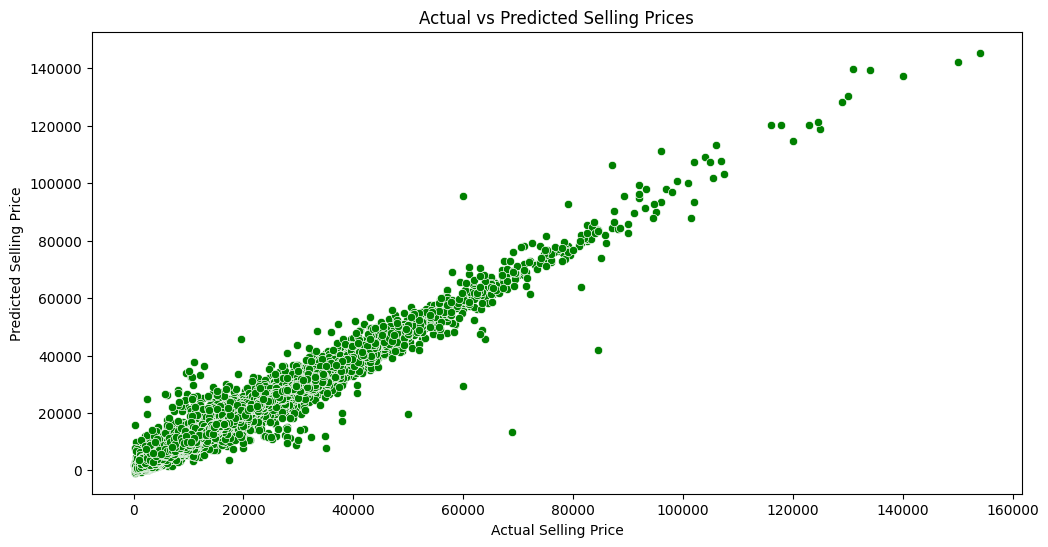

In [117]:
### Step 7: Visualization of Results
#Plotting Predictions vs Actuals
import matplotlib.pyplot as plt
import seaborn as sns
predictions_pd = predictions.select("sellingprice", "prediction").toPandas()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='sellingprice', y='prediction', data=predictions_pd, color='Green')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Prices')
plt.show()

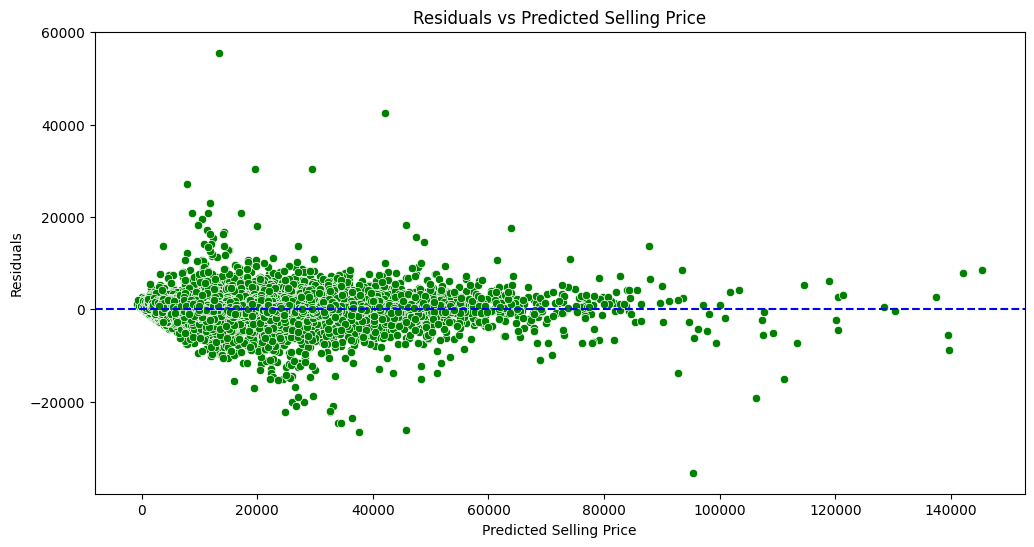

In [118]:
# Residuals vs Predicted
predictions_pd["residuals"] = predictions_pd["sellingprice"] - predictions_pd["prediction"]

# Plot the scatterplot with the correct variable name
plt.figure(figsize=(12, 6))
sns.scatterplot(x="prediction", y="residuals", data=predictions_pd, color="Green")
plt.axhline(y=0, color="blue", linestyle="--")
plt.xlabel("Predicted Selling Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Selling Price")
plt.show()

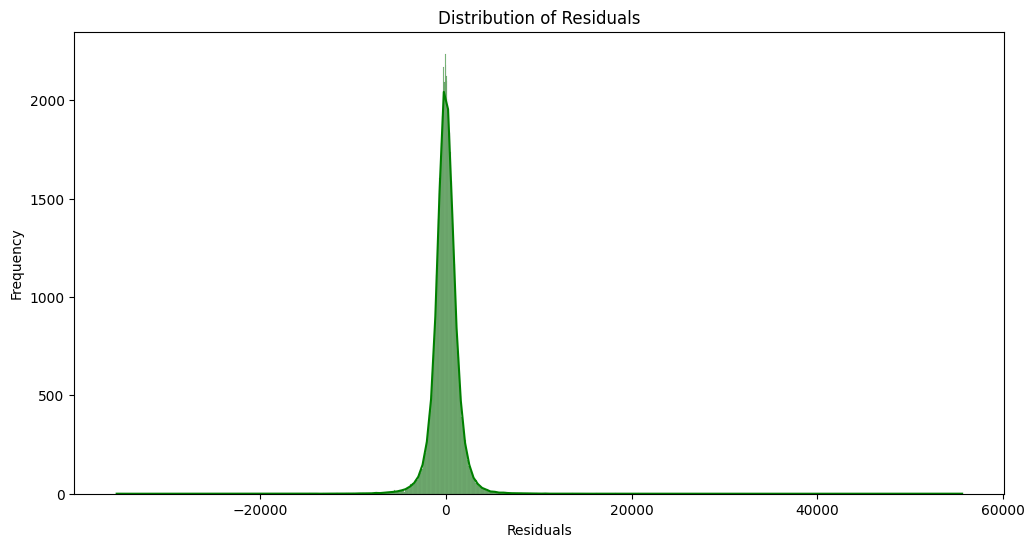

In [119]:
# Distribution of Residuals
predictions_pd["residuals"] = predictions_pd["sellingprice"] - predictions_pd["prediction"]
plt.figure(figsize=(12, 6))
sns.histplot(predictions_pd['residuals'], kde=True, color='Green')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

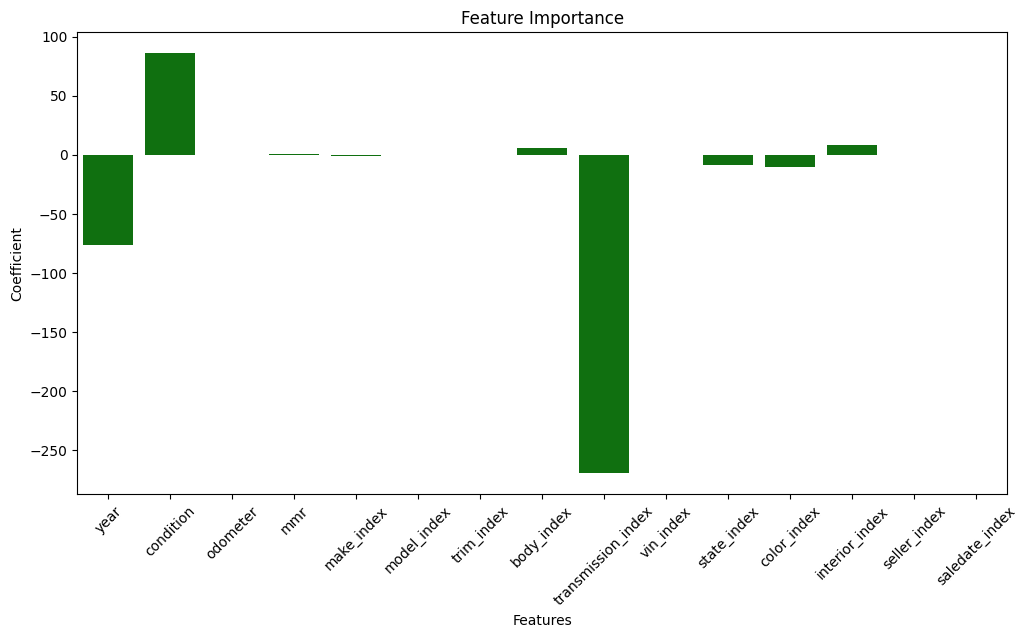

In [120]:
# Feature Importance
import pandas as pd

coefficients = lr_model.coefficients
feature_importance = pd.DataFrame(coefficients, index=feature_columns, columns=['Coefficient'])

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.index, y='Coefficient', data=feature_importance, color='Green')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()

In [121]:
#Check for Multicollinearity
import numpy as np
# Calculate VIF
vif_data = pd.DataFrame()
vif_data["new_feature"] = correlation_matrix.columns
vif_data["VIF"] = [1 / (1 - np.linalg.det(correlation_matrix.values)) for i in range(correlation_matrix.shape[1])]

print(vif_data)

    new_feature       VIF
0          year  1.004041
1     condition  1.004041
2      odometer  1.004041
3           mmr  1.004041
4  sellingprice  1.004041


In [122]:
from pyspark.sql.functions import mean, stddev

# Calculate mean and standard deviation for the sellingprice
stats = Car_Price_Clean.select(mean(col("sellingprice")), stddev(col("sellingprice"))).first()
mean_value = stats[0]
stddev_value = stats[1]

# Calculate Z-score and filter outliers
z_threshold = 3
Car_Price_No_Outliers = Car_Price_Clean.withColumn("z_score", (col("sellingprice") - mean_value) / stddev_value)
Car_Price_No_Outliers = Car_Price_No_Outliers.filter(col("z_score").between(-z_threshold, z_threshold))

Car_Price_No_Outliers.show(5)

+----+-----+--------+--------------------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+-------------------+
|year| make|   model|                trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|            saledate|            z_score|
+----+-----+--------+--------------------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+-------------------+
|2014|  BMW|3 Series|          328i SULEV|Sedan|   automatic|wba3c1c51ek116351|   ca|       45|    1331| gray|   black|financial service...|31900|       30000|Thu Jan 15 2015 0...| 1.7233015727467265|
|2015|Volvo|     S60|                  T5|Sedan|   automatic|yv1612tb4f1310987|   ca|       41|   14282|white|   black|volvo na rep/worl...|27500|       27750|Thu Jan 29 2015 0...| 1.4844157940313

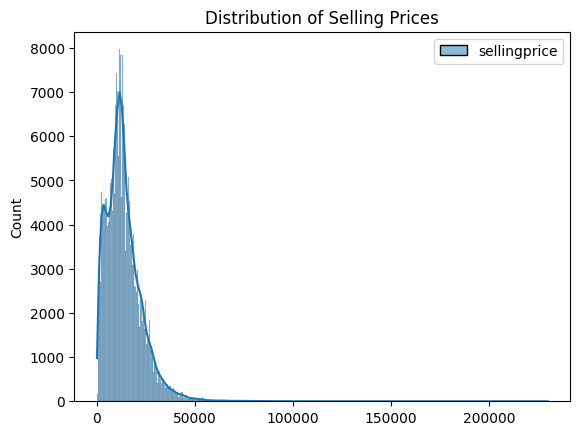

In [123]:
from scipy.stats import shapiro

# Convert to Pandas DataFrame
selling_prices = Car_Price_Clean.select("sellingprice").toPandas()

# Q-Q plot
sns.histplot(selling_prices, kde=True)
plt.title("Distribution of Selling Prices")
plt.show()


In [124]:

# Shapiro-Wilk test
stat, p_value = shapiro(selling_prices)
print(f"Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}")

Shapiro-Wilk Test: Statistics=0.8828036785125732, p-value=0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [125]:

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors


# Apply PCA
pca = PCA(k=5, inputCol="new_features", outputCol="pcaFeatures")
pca_model = pca.fit(data)
data_pca = pca_model.transform(data)

# Update feature column to pcaFeatures
train_data, test_data = data_pca.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="pcaFeatures", labelCol="sellingprice")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

In [126]:
evaluator_mae = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)



In [127]:
evaluator_r2 = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 1584.4253137539802
Mean Absolute Error (MAE): 1030.2208640898868
R-squared (R²): 0.9715400608762438


In [128]:
# Polynomial Features for Feature engineering
feature_eng = ["year", "condition", "transmission_index"]
assembler = VectorAssembler(inputCols=feature_eng, outputCol="features_poly")
data = assembler.transform(data)
data.show(5)


+----+-----+-------------------+--------------------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+--------------------+----------+-----------+----------+----------+------------------+---------+-----------+-----------+--------------+------------+--------------+--------------------+-----------------+
|year| make|              model|                trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|            saledate|            features|make_index|model_index|trim_index|body_index|transmission_index|vin_index|state_index|color_index|interior_index|seller_index|saledate_index|        new_features|    features_poly|
+----+-----+-------------------+--------------------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+--------------------+--

In [129]:
#Hyperparameter Tuning and Cross-Validation
# Initialize Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="sellingprice")

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define Evaluator
evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="rmse")

# Initialize CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)


In [130]:
#Making Predictions and Evaluating the Model
# Make predictions on test data
predictions = cvModel.transform(test_data)
predictions.select("prediction", "sellingprice", "features").show(5)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
r2_evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


+------------------+------------+--------------------+
|        prediction|sellingprice|            features|
+------------------+------------+--------------------+
| 990.3803037435864|        1200|[1997.0,19.0,1462...|
| 723.5284926206805|         850|[1997.0,19.0,2242...|
|  1922.90082799815|        1350|[1997.0,25.0,1242...|
|1971.5448158186628|        1700|[1997.0,19.0,1561...|
| 2174.627747798979|        2000|[1997.0,36.0,1874...|
+------------------+------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE): 1467.4784969019959
R-squared (R²): 0.9755862825207416


In [131]:
spark.stop()
